# <center> Fast Fourier Transformation


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import scipy.fft
from scipy import signal
from scipy.fft import fftshift
from math import sqrt
from sklearn.metrics import mean_squared_error
import plotly
from matplotlib import mlab
from matplotlib.ticker import MaxNLocator

In [2]:
#import data
minute = pd.read_excel('ml_dataset.xlsx',sheet_name='Minute', index_col=0, parse_dates=True)
hour = pd.read_excel('ml_dataset.xlsx',sheet_name='Hour', index_col=0, parse_dates=True)
day = pd.read_excel('ml_dataset.xlsx',sheet_name='Day', index_col=0, parse_dates=True)
week = pd.read_excel('ml_dataset.xlsx',sheet_name='Week', index_col=0, parse_dates=True)
month = pd.read_excel('ml_dataset.xlsx',sheet_name='Month', index_col=0, parse_dates=True)

In [3]:
def fourier_predict(x, k, num_components, d):
    """
    :param x: timeseries data
    :param k: prediction horizon
    :param num_components: number of fourier components to keep
    :param d: sampling rate
    """
    #find freqs for largest PSD components
    
    n = x.size
    #compute fourier transform
    x_fft = scipy.fft.fft(x)
    
    #compute power spectral density
    x_psd = np.abs(x_fft)**2
    
    #compute fourier frequencies
    freqs = scipy.fft.fftfreq(n,d)
    
    #find largest PSD components
    idxs_psd_freqs = list(range(len(freqs)))
    idxs_psd_freqs.sort(key = lambda i: np.log10(x_psd[i]), reverse=True)
   
    #find top frequencies used
    tot = 2*num_harm
    top_idx = idxs_psd_freqs[:tot]
    top_freqs = []
    for val in top_idx:
        freq = freqs[val]
        top_freqs.append(freq)

    #reconstitute the timeseries with the fourier frequencies
    t = np.arange(0, n + k)
    signal = np.zeros(t.size)
    for j in idxs_psd_freqs[:1 + 2*num_components]:
        magnitude = np.abs(x_fft[j])/n
        phase_angle = np.angle(x_fft[j])
        signal += magnitude * np.cos(2 * np.pi * freqs[j] * d * t + phase_angle)
        
    
    predict = signal[0:n]
    forecast = signal[n:n+k]

    return signal, predict, forecast, top_freqs

In [4]:
#Get Testing RMSE
def get_rmse(true, sig, len_train):
    """
    :param true: array of true signal
    :param sig: array of predictions
    :param len_train: training split of data
    """
    test_pred = sig[len_train:]
    rmse = sqrt(mean_squared_error(true[len_train:], test_pred))
    print('Test RMSE: %.3f' % rmse)

In [5]:
#Find top num_harm most common frequencies
def get_freqs(frequency):
     """
    :param frequency: frequency aray returned by fourier_predict
    """
     #Create list of positive frequencies and round values
     pos_freqs = [ele for ele in frequency if ele > 0]
     pos_freqs_rounded = []
     for val in pos_freqs:
        num = round(val, 5)
        pos_freqs_rounded.append(num)

     print('The top frequencies found were:')
     for val in pos_freqs_rounded:
        print(f'{val} Hz')

In [6]:
#Plot the original signal, fourier transform, and error
#Returns the RMSE and the top frequencies found
def plot_fourier_predict(df, timestep, k, frequency):
     """
    :param df: df of fourier prediction
    :param timestep: interval of time series data
    :param error: error 
    k: prediction horizon
    frequency: frequency returned by fourier_predict
    """
     fig, ax = plt.subplots(2,1,figsize=(15,10), facecolor='w', edgecolor='k')
     
     if timestep == 'hour':
        ax[0].plot(df['convolved'],'g',label='True')
        ax[0].plot(df['fourier'],'b',label='Forecast')
        ax[1].plot(df['error'], 'r', label = 'Error')
        get_rmse(df['convolved'], df['fourier'], k)
     elif timestep == '15-minute':
        ax[0].plot(df['convolved'],'g',label='True')
        ax[0].plot(df['fourier'],'b',label='Forecast')
        ax[1].plot(df['error'], 'r', label = 'Error')
        get_rmse(df['convolved'], df['fourier'], k)
     else:
        ax[0].plot(df['grid'],'g',label='True')
        ax[0].plot(df['fourier'],'b',label='Forecast')
        ax[1].plot(df['error'], 'r', label = 'Error')
        get_rmse(df['grid'], df['fourier'], k)

     for i in range(2):
        ax[i].set_ylabel('Normalized Energy Consumption')
        ax[i].legend()
        if i==0:
            ax[i].axvline(x=['2016-01'], c='black', lw=3)
            ax[i].set_title('Average Home Load Forecast, Fourier Frequencies: ' + str(num_harm))
        else:
            ax[i].set_xlabel(f'{timestep.title()} Intervals')

     get_freqs(frequency)

# <center> Signal Analysis

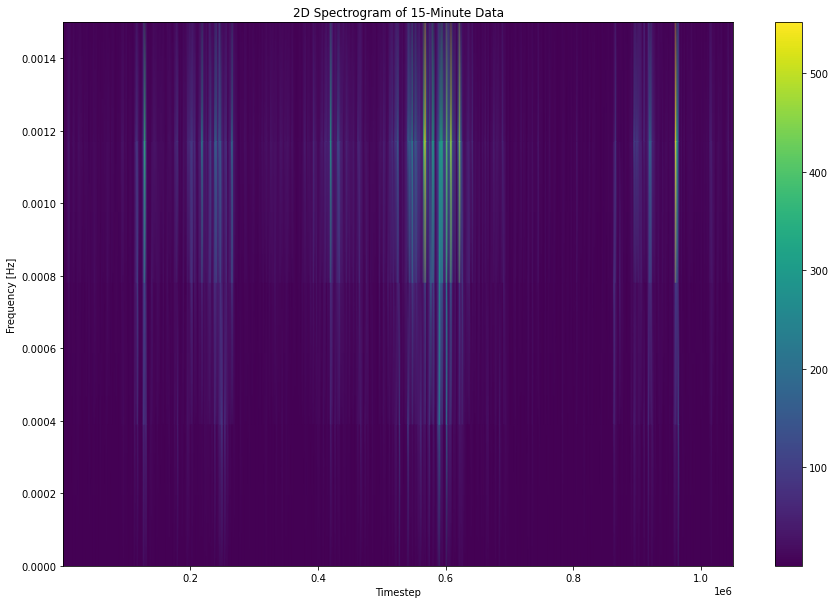

In [7]:
#Compute spectrogram on 15-minute data
fig, ax = plt.subplots(1,1,figsize=(15,10), facecolor='w', edgecolor='k')
f, t, Sxx = signal.spectrogram(minute['grid'], 1/10)
im = ax.pcolormesh(t, f, Sxx,  shading='gouraud')
fig.colorbar(im, ax=ax)
plt.ylim([0,.0015])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.title('2D Spectrogram of 15-Minute Data')
plt.show()  

In [8]:
#Create a 3D spectrogram of the electrical grid signals
def spectrogram_3d(x, ax=None):
     """
    :param x: timeseries grid data
    :param ax: matplotlib axis object
    """
     if ax:
        ax = plt.axes(projection='3d')
        freqs, t, spec = signal.spectrogram(x, 1/12)
        X, Y, Z = t[None, :], freqs[:, None],  20.0 * np.log10(spec)
        im = ax.plot_surface(X,Y,Z, cmap='viridis')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlabel('Timestep')
        ax.set_zlabel('Magnitude')
        return im

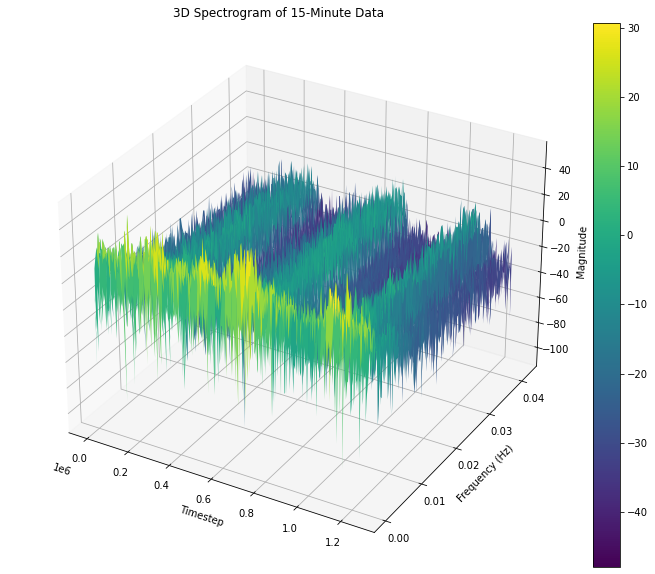

In [9]:
#Plot 3D spectrogram 
fig, ax = plt.subplots(figsize=(15,10), facecolor='w', edgecolor='k',subplot_kw={'projection': '3d'})
im = spectrogram_3d(minute['grid'], ax=ax)
fig.colorbar(im, ax=ax)
ax.set_title('3D Spectrogram of 15-Minute Data')
plt.show()

# <center> Monthly Predictions

In [10]:
#split the data into training and testing sets 
#36 months total
y_train = month['grid'].values[0:24]
y_test = month['grid'].values[24:]

#predict and forecast the timeseries using fourier decomposition
d = 1/12
k = 12
num_harm = 3
month_signal, month_predict, month_forecast, month_frequency  = fourier_predict(y_train, k, num_harm, d)

#define error in model
month_error = month['grid'].values-month_signal

month['fourier'] = month_signal
month['error'] = month_error

Test RMSE: 0.114
The top frequencies found were:
1.0 Hz
2.0 Hz
1.5 Hz


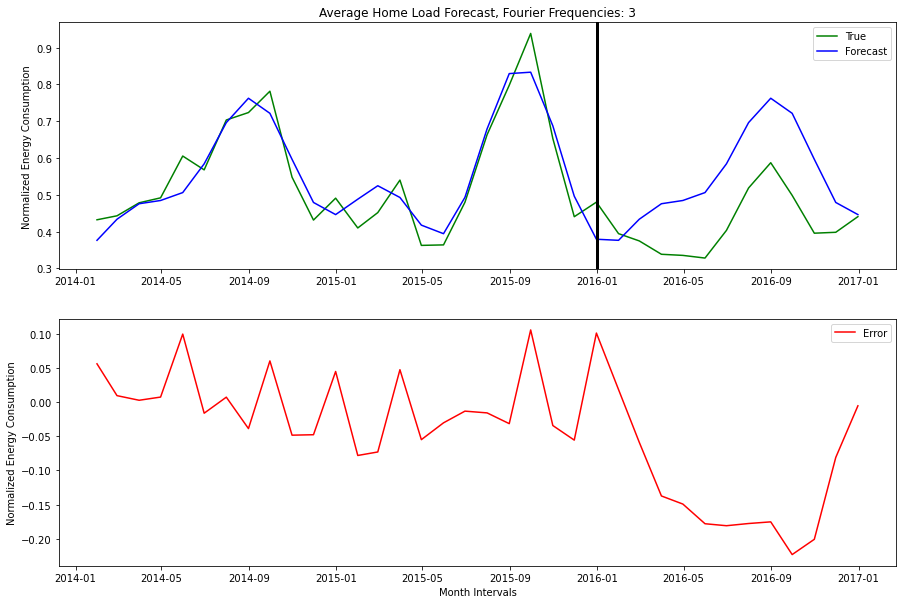

In [11]:
plot_fourier_predict(month, 'month', k, month_frequency)

# <center> Weekly Predictions

In [12]:
#split the data into training and testing sets 
#157 weeks total
y_train = week['grid'].values[0:105]
y_test = week['grid'].values[105:]

#predict and forecast the timeseries using fourier decomposition
d = 1/12
k = 52
num_harm = 5
week_signal, week_predict, week_forecast, week_frequency  = fourier_predict(y_train, k, num_harm, d)

#define error in model
week_error = week['grid'].values-week_signal

week['fourier'] = week_signal
week['error'] = week_error

Test RMSE: 0.140
The top frequencies found were:
0.22857 Hz
0.45714 Hz
0.34286 Hz
0.91429 Hz
0.68571 Hz


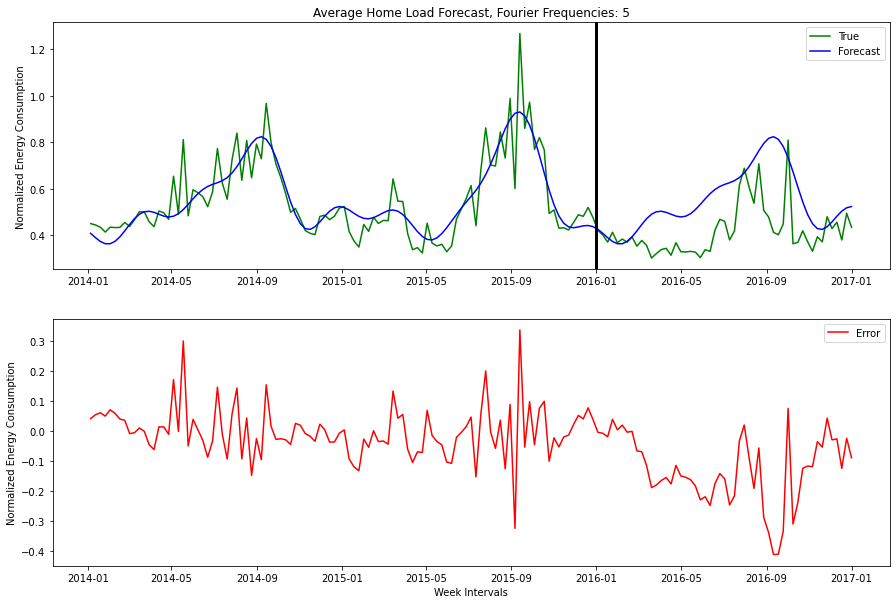

In [13]:
plot_fourier_predict(week, 'week', k, week_frequency)

# <center> Daily Predictions

In [14]:
#split the data into training and testing sets 
#1096 days total
y_train = day['grid'].values[0:730]
y_test = day['grid'].values[730:]

#predict and forecast the timeseries using fourier decomposition
d = 1/12
k = 366
num_harm = 4
day_signal, day_predict, day_forecast, day_frequency  = fourier_predict(y_train, k, num_harm, d)

#define error in model
day_error = day['grid'].values-day_signal

day['fourier'] = day_signal
day['error'] = day_error

Test RMSE: 0.168
The top frequencies found were:
0.03288 Hz
0.06575 Hz
0.04932 Hz
0.13151 Hz


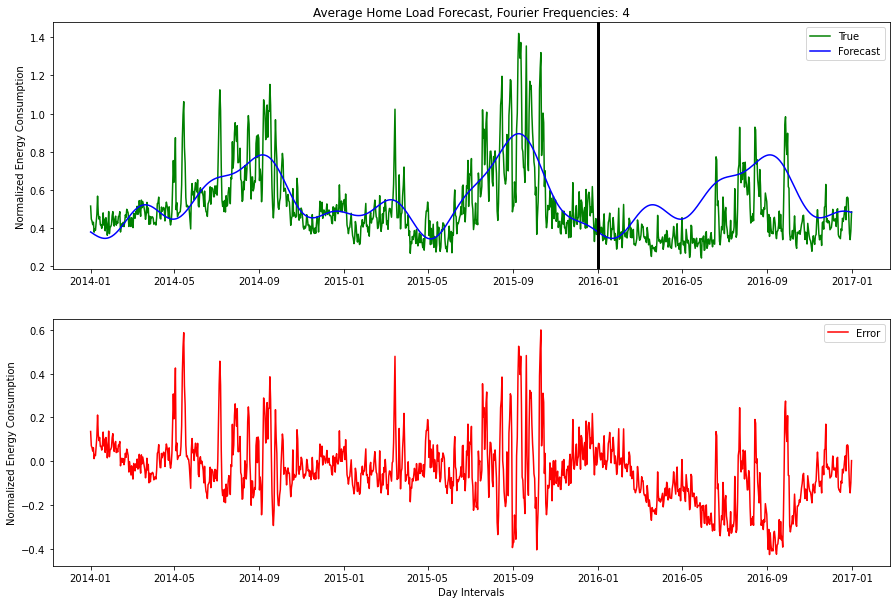

In [15]:
plot_fourier_predict(day, 'day', k, day_frequency)

# <center> Hourly Predictions

In [16]:
#split the data into training and testing sets 
#26304 hours total
y_train = hour['convolved'].values[0:17536]
y_test = hour['convolved'].values[17536:]

#predict and forecast the timeseries using fourier decomposition
d = 1/12
k = 8768
num_harm = 7
hour_signal, hour_predict, hour_forecast, hour_frequency  = fourier_predict(y_train, k, num_harm, d)

#define error in model
hour_error = hour['convolved'].values-hour_signal

hour['fourier'] = hour_signal
hour['error'] = hour_error

Test RMSE: 0.144
The top frequencies found were:
0.00137 Hz
0.00274 Hz
0.00205 Hz
0.00547 Hz
0.00411 Hz
0.00684 Hz
0.00068 Hz


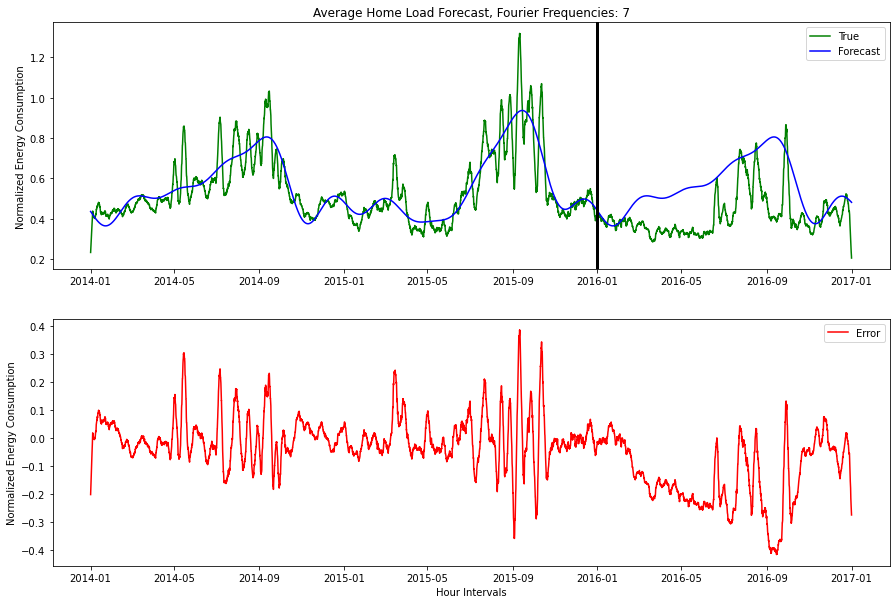

In [17]:
plot_fourier_predict(hour, 'hour', k, hour_frequency)

# <center> 15 Minute Predictions

In [18]:
#split the data into training and testing sets 
#105205 15-minute intervals total
y_train = minute['convolved'].values[0:70136]
y_test = minute['convolved'].values[70136:]


#predict and forecast the timeseries using fourier decomposition
d = 1/12
k = 35068
num_harm = 3
minute_signal, minute_predict, minute_forecast, minute_frequency  = fourier_predict(y_train, k, num_harm, d)

#define error in model
minute_error = minute['convolved'].values-minute_signal

minute['fourier'] = minute_signal
minute['error'] = minute_error

Test RMSE: 0.117
The top frequencies found were:
0.00034 Hz
0.00068 Hz
0.00051 Hz


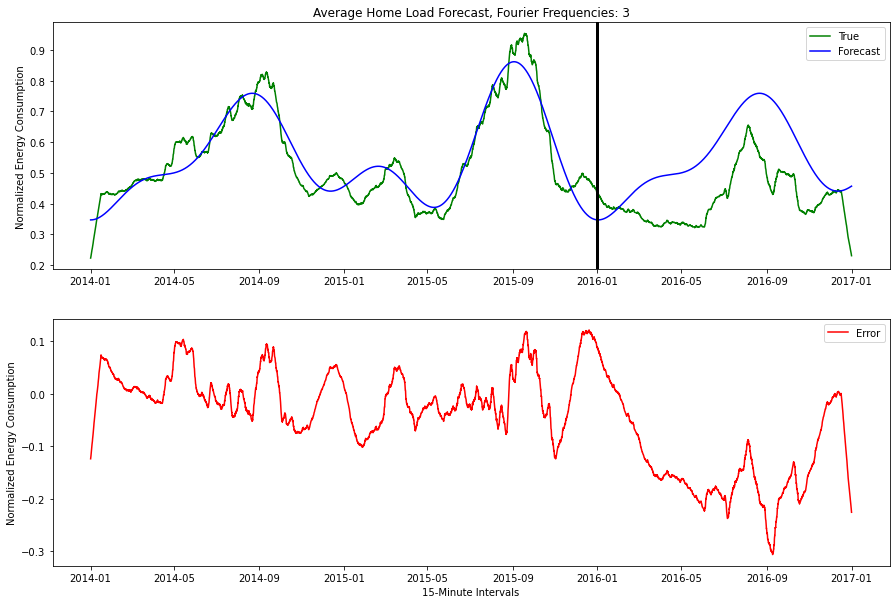

In [19]:
plot_fourier_predict(minute, '15-minute', k, minute_frequency)